# Assignment 1

Machine Learning (BBWL), Michael Mommert, FS2023, University of St. Gallen

The **goal** of this assignment is to implement a $k$-Nearest Neighbor (kNN) classifier that performs classification on the accompanied dataset. The dataset is 5-dimensional and consists of numerical features, only. Each datapoint belongs to either of three classes. Train a kNN classifier in such a way as to maximize its performance and to generalize well.

The general **objectives** are:
* to implement the ML pipeline using *scikit-learn* as discussed in the lecture and the lab course, following best practices;
* to properly perform hyperparameter tuning from which clearly follows which value of $k$ has been chosen and why;
* to compare the performance of the best trained model on the training, validation and test datasets, preventing both overfitting and underfitting.

This assignment will be **graded** based on:
* whether these objectives have been achieved;
* whether the solution follows best practices;
* how well the approach is documented (e.g., using text cells, plots, etc.);
* how clean the code is;
* the performance of the trained model.

There are no restrictions on the resources that you can use -- collaborating on assignments is allowed -- but students are not allowed to submit identical code.

Please submit your runnable Notebook to [michael.mommert@unisg.ch](mailto:michael.mommert@unisg.ch) **before 26 March 2023, 23:59**. Please include your name in the Notebook filename.

-----

The following code cell will import the dataset used in this assignment. Please do not modify this code cell.

In [1]:
import numpy as np
from urllib.request import urlopen
from io import BytesIO

# load data as binary npy file
raw_data = np.load(BytesIO(urlopen("https://raw.githubusercontent.com/HSG-AIML-Teaching/MLBBWL-2023FS/main/assignment_1/data.npy").read()))

x = raw_data[:,:5]  # this is your input data
y = raw_data[:, 5]  # this is your target vector

x.shape, y.shape

((2000, 5), (2000,))

-----

## 1. Setup Environment
Load all necessary libraries for later use in the notebook.

In [16]:
# import sklearn data and data pre-processing libraries
from sklearn import datasets
from sklearn.model_selection import train_test_split

# import sklearn scalers
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import MaxAbsScaler
from sklearn.preprocessing import Normalizer

# import sklearn kNN classifier
from sklearn.neighbors import KNeighborsClassifier

# import matplotlib data visualization library
import matplotlib.pyplot as plt

# import seaborn data visualization library
import seaborn as sns
from seaborn import color_palette

# import pandas data manipulation library
import pandas as pd

----

## 2. Inspect Data
### 2.1 Turn data into Pandas Dataframe for easier handling

In [3]:
# convert data to pandas dataframe
df = pd.DataFrame(x, columns=["feature1", "feature2", "feature3", "feature4", "feature5"])

# add target vector to dataframe
df["target"] = y

# show first 5 rows of dataframe
df.head()

,feature1,feature2,feature3,feature4,feature5,target
0,-2.109198,-1.443881,-0.100620,-90.916762,-0.893275,2.0
1,-4.469359,-0.237587,-0.116520,3.983598,0.121665,1.0
2,5.754084,-0.459973,0.079301,-87.950730,-0.062872,2.0
3,-2.314240,1.162550,-0.015752,91.994132,0.973047,1.0
4,5.211160,-0.431351,0.063959,-85.552838,0.038414,2.0


### 2.2 Inspect classes & features

In [7]:
# show all classes in target vector and their counts
df["target"].value_counts()

1.0    672
2.0    665
0.0    663
Name: target, dtype: int64

In [12]:
# describe data statistics for all features
df[["feature1", "feature2", "feature3", "feature4", "feature5"]].describe()


,feature1,feature2,feature3,feature4,feature5
count,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000
mean,1.096012,-0.229969,0.000177,-33.328937,0.031146
std,6.653817,1.255480,0.136667,114.778567,1.470083
min,-17.619118,-3.170769,-0.417241,-472.896324,-5.116405
25%,-3.814481,-1.204328,-0.106079,-115.331424,-1.020432
50%,1.570310,-0.428828,0.013511,-65.033330,0.053778
75%,6.058712,0.586570,0.100640,56.000243,1.157113
max,20.650067,4.576527,0.394804,461.971693,3.977298


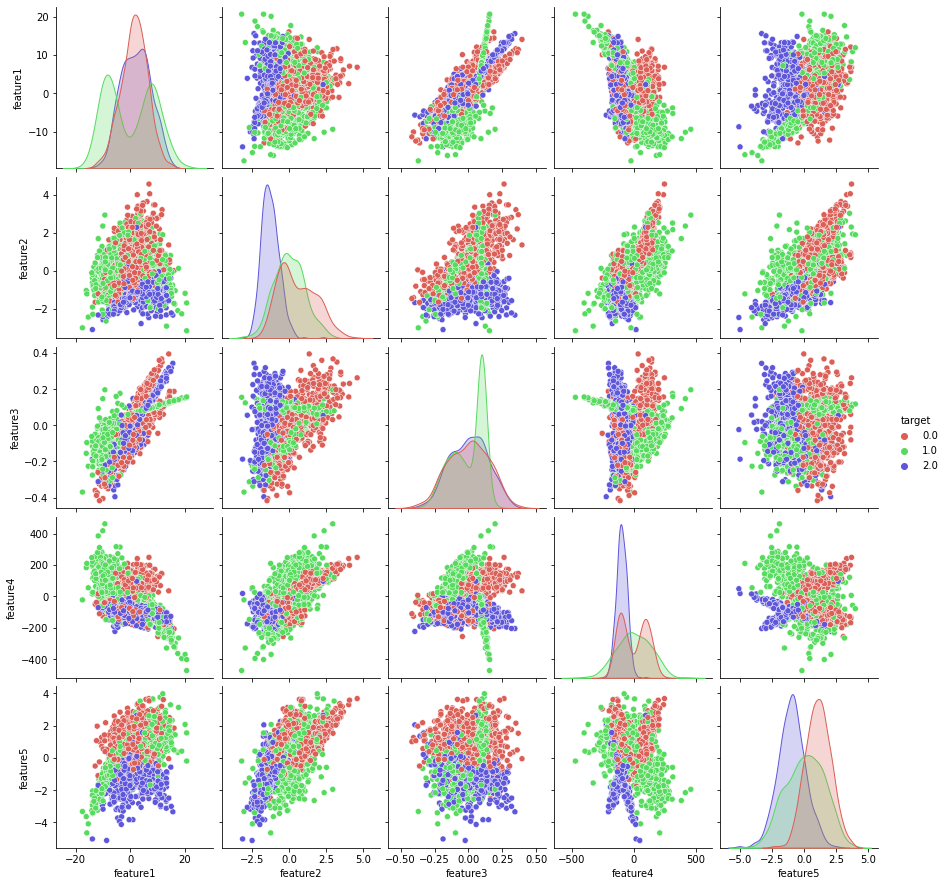

<Figure size 432x288 with 0 Axes>

In [13]:
# plot the distribution of the features
plt.show(sns.pairplot(df, hue='target', palette=color_palette("hls", 3)))
plt.clf()

### 2.3 Conclusion
We have 3 discrete quantitative classes that are roughly the same size. Additionally we have 2000 rows of data which should provide an adequate amount of data to work with. Unfortunately no column names were provided for the 5 features (quantitative continuous) which leaves us to guess what the data is from. Column statistics and the pairplot show that the data has quite a usual distribution without many outliers. Additionally the 3 classes exhibit non-linear separability.

-----

## 3. Feature Engineering

Data is already available in the form of quantitative data (continuous input data and discrete class labels), which we directly feed into our ML models. Therefore, no feature engineering required.

-----

## 4. Simple approach

In this notebook we will first do a quick run through without optimizing our ML model. Then in the next chapter we will optimize our ML model and compare the improvements. For the quick run through we will guess (fair best guess) certain inputs such as k (10) & scaler (standard scaler).

### 4.1 Data scaling

In [14]:
# scale data using StandardScaler
standard_scaler = StandardScaler()
standard_scaled_data = standard_scaler.fit_transform(x)

### 4.2 Data splitting

Since we wil not do any fine tuning, there is no need for a validation set and we could split right away to 85% / 15% since the test data in the advanced ML model will also be 15%. However to get a fair comparison we need to have the same amount of training / test data for both approachess. Thus splitting 70% / 15% / 15% and "ignoring" the validation part.

In [15]:
# split data into training, validation and test set (70%, 15%, 15%) using stratified sampling
x_train, x_test, y_train, y_test = train_test_split(standard_scaled_data, y, test_size=0.3, random_state=42, stratify=y)
x_val, x_test, y_val, y_test = train_test_split(x_test, y_test, test_size=0.5, random_state=42, stratify=y_test)

# show the shape of the training, validation and test set
x_train.shape, x_val.shape, x_test.shape

((1400, 5), (300, 5), (300, 5))

### 4.3 Train model

In [17]:
# create a kNN classifier with k=10
knn = KNeighborsClassifier(n_neighbors=10)

# fit the classifier to the training data
knn.fit(x_train, y_train)

KNeighborsClassifier(n_neighbors=10)

### 4.4 Evaluate model on test data set

In [18]:
# predict the target vector for the test set
y_pred = knn.predict(x_test)

# show the accuracy of the classifier on the test set
knn.score(x_test, y_test)

0.8566666666666667

Now we have one issue. The evaluation is only valid for a split with random_state 42. We could be super lucky or unfortunate and the result of a prediction with a different split selection could be a lot different. Thus we can use

In [19]:
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score

# split data into training, validation and test set (70%, 15%, 15%) using stratified sampling
x_train_val, x_test, y_train_val, y_test = train_test_split(standard_scaled_data, y, test_size=0.15, random_state=42, stratify=y)
x_train, x_val, y_train, y_val = train_test_split(x_train_val, y_train_val, test_size=0.1765, random_state=42, stratify=y_train_val)

# create a kNN classifier with k=10
knn = KNeighborsClassifier(n_neighbors=10)

# define the number of folds for K-Fold Cross Validation
n_splits = 5

# create KFold object
kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)

# lists to store the accuracy scores for each fold
train_scores = []
val_scores = []

# perform K-Fold Cross Validation
for train_index, val_index in kf.split(x_train_val, y_train_val):
    # get the training and validation data for this fold
    x_train_fold, x_val_fold = x_train_val[train_index], x_train_val[val_index]
    y_train_fold, y_val_fold = y_train_val[train_index], y_train_val[val_index]
    
    # fit the classifier to the training data for this fold
    knn.fit(x_train_fold, y_train_fold)
    
    # evaluate the classifier on the training data for this fold
    train_score = knn.score(x_train_fold, y_train_fold)
    train_scores.append(train_score)
    
    # evaluate the classifier on the validation data for this fold
    val_score = knn.score(x_val_fold, y_val_fold)
    val_scores.append(val_score)

# calculate the mean and standard deviation of the accuracy scores for each fold
mean_train_score = np.mean(train_scores)
std_train_score = np.std(train_scores)
mean_val_score = np.mean(val_scores)
std_val_score = np.std(val_scores)

# fit the classifier to the training data with the best hyperparameters (k=10)
knn.fit(x_train, y_train)

# predict the target vector for the test set
y_pred = knn.predict(x_test)

# show the accuracy of the classifier on the test set
test_score = accuracy_score(y_test, y_pred)

# show the mean and standard deviation of the accuracy scores for each fold and the test score
print(f"Mean train score: {mean_train_score:.3f} +/- {std_train_score:.3f}")
print(f"Mean val score: {mean_val_score:.3f} +/- {std_val_score:.3f}")
print(f"Test score: {test_score:.3f}")

Mean train score: 0.885 +/- 0.004
Mean val score: 0.867 +/- 0.020
Test score: 0.870


----

In [6]:
# scale the data using robust scaler
robust_scaler = RobustScaler()
robust_scaled_data = robust_scaler.fit_transform(x)

# scale the data using standard scaler
standard_scaler = StandardScaler()
standard_scaled_data = standard_scaler.fit_transform(x)

# scale the data using minmax scaler
minmax_scaler = MinMaxScaler()
minmax_scaled_data = minmax_scaler.fit_transform(x)

# scale the data using maxabs scaler
maxabs_scaler = MaxAbsScaler()
maxabs_scaled_data = maxabs_scaler.fit_transform(x)

# scale the data using normalizer
normalizer = Normalizer()
normalizer_scaled_data = normalizer.fit_transform(x)

In [14]:
# define random state
random_state = 42

# define test size
test_size = 0.3

# split the data into training and remainder set
x_train, x_remainder, y_train, y_remainder = train_test_split(minmax_scaled_data, y, test_size=test_size, random_state=random_state, stratify=y)

# split the remaindar data into validation and test set
x_val, x_test, y_val, y_test = train_test_split(x_remainder, y_remainder, test_size=0.5, random_state=random_state, stratify=y_remainder)

In [43]:
# don't show future warnings
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# define k (select random k for now)
k = 10

# import KNN classifier
from sklearn.neighbors import KNeighborsClassifier

# define KNN classifier
knn = KNeighborsClassifier(n_neighbors=k)

# fit the model
knn.fit(x_train, y_train)

# import accuracy score
from sklearn.metrics import accuracy_score

# predict the labels of the validation set
y_pred = knn.predict(x_val)

# compute the accuracy score
accuracy_score(y_val, y_pred)




0.8533333333333334

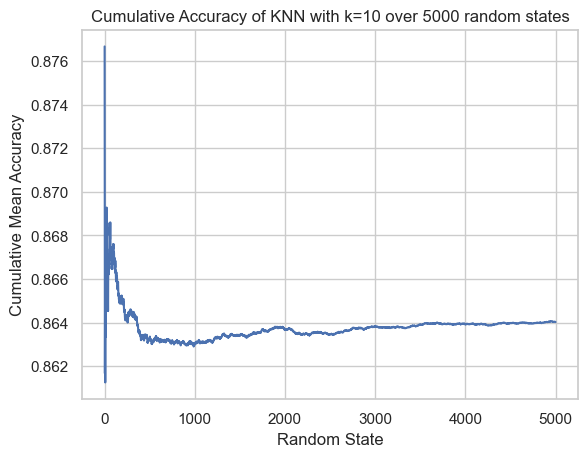

In [48]:
from sklearn.model_selection import cross_val_score

# define k value
k = 10

# define random states
random_states = range(1, 5001)

# define accuracies
accuracies = []

# loop over random states
for random_state in random_states:
    # split the data into training and remainder set
    x_train, x_remainder, y_train, y_remainder = train_test_split(robust_scaled_data, y, test_size=test_size, random_state=random_state, stratify=y)

    # split the remainder data into validation and test set
    x_val, x_test, y_val, y_test = train_test_split(x_remainder, y_remainder, test_size=0.5, random_state=random_state, stratify=y_remainder)

    # define KNN classifier
    knn = KNeighborsClassifier(n_neighbors=k)

    # fit the model
    knn.fit(x_train, y_train)

    # predict the labels of the validation set
    y_pred = knn.predict(x_val)

    # compute the accuracy score
    accuracies.append(accuracy_score(y_val, y_pred))

# compute the cumulative average accuracies for each random state
cumulative_mean_accuracies = np.cumsum(accuracies) / np.arange(1, len(random_states)+1)

# plot the cumulative mean accuracies
plt.plot(random_states, cumulative_mean_accuracies)
plt.xlabel("Random State")
plt.ylabel("Cumulative Mean Accuracy")
plt.title("Cumulative Accuracy of KNN with k=10 over 5000 random states")
plt.show()

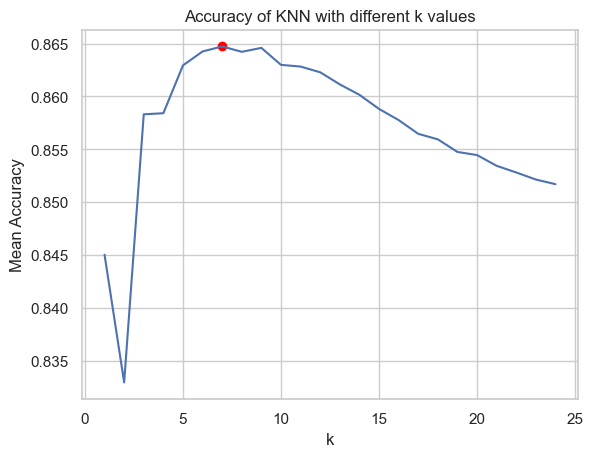

K with highest accuracy: 7. Accuracy: 0.8647247247247247


In [49]:
from operator import length_hint
from sklearn.model_selection import cross_val_score

# define k values
k_values = range(1, 25)

# define random states
random_states = range(1, 1000)

# define accuracies
accuracies = []

# loop over k values
for k in k_values:
    # loop over random states
    for random_state in random_states:
        # split the data into training and remainder set
        x_train, x_remainder, y_train, y_remainder = train_test_split(robust_scaled_data, y, test_size=test_size, random_state=random_state, stratify=y)

        # split the remainder data into validation and test set
        x_val, x_test, y_val, y_test = train_test_split(x_remainder, y_remainder, test_size=0.5, random_state=random_state, stratify=y_remainder)

        # define KNN classifier
        knn = KNeighborsClassifier(n_neighbors=k)

        # fit the model
        knn.fit(x_train, y_train)

        # predict the labels of the validation set
        y_pred = knn.predict(x_val)

        # compute the accuracy score
        accuracies.append(accuracy_score(y_val, y_pred))

# compute the average accuracies for each k value
mean_accuracies = np.array(accuracies).reshape(-1, len(random_states)).mean(axis=1)

# find the k value with the highest accuracy
best_k = k_values[np.argmax(mean_accuracies)]
best_accuracy = mean_accuracies.max()

# plot the mean accuracies and mark the maximum accuracy and k value
plt.plot(k_values, mean_accuracies)
plt.scatter(best_k, best_accuracy, color='red')
plt.xlabel("k")
plt.ylabel("Mean Accuracy")
plt.title("Accuracy of KNN with different k values")
plt.show()

# print the k value with the highest accuracy including the corresponding accuracy
best_index = np.argmax(mean_accuracies)
print("K with highest accuracy: {}. Accuracy: {}".format(best_k, best_accuracy))

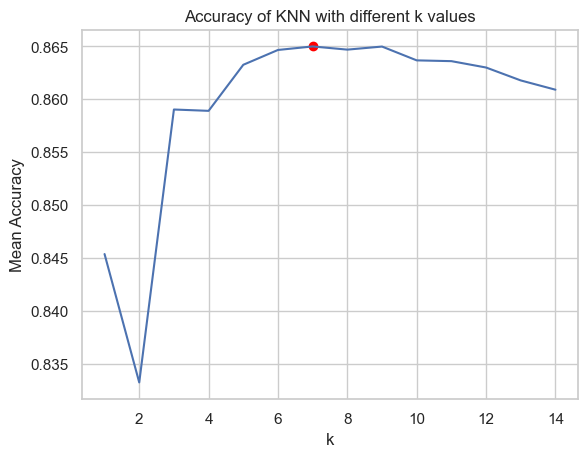

K with highest accuracy: 7. Accuracy: 0.8649858262464565


In [55]:
from joblib import Parallel, delayed
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
import numpy as np
import matplotlib.pyplot as plt

# define k values
k_values = range(1, 15)

# define random states
random_states = range(1, 2000)

# define function to compute accuracy for a given k value and random state
def compute_accuracy(k, random_state):
    # split the data into training and remainder set
    x_train, x_remainder, y_train, y_remainder = train_test_split(robust_scaled_data, y, test_size=test_size, random_state=random_state, stratify=y)

    # split the remainder data into validation and test set
    x_val, x_test, y_val, y_test = train_test_split(x_remainder, y_remainder, test_size=0.5, random_state=random_state, stratify=y_remainder)

    # define KNN classifier
    knn = KNeighborsClassifier(n_neighbors=k)

    # fit the model
    knn.fit(x_train, y_train)

    # predict the labels of the validation set
    y_pred = knn.predict(x_val)

    # compute the accuracy score
    return accuracy_score(y_val, y_pred)

# loop over k values in parallel
results = Parallel(n_jobs=-1)(delayed(compute_accuracy)(k=k, random_state=random_state) for k in k_values for random_state in random_states)

# compute the average accuracies for each k value
mean_accuracies = np.array(results).reshape(-1, len(random_states)).mean(axis=1)

# find the k value with the highest accuracy
best_k = k_values[np.argmax(mean_accuracies)]
best_accuracy = mean_accuracies.max()

# plot the mean accuracies and mark the maximum accuracy and k value
plt.plot(k_values, mean_accuracies)
plt.scatter(best_k, best_accuracy, color='red')
plt.xlabel("k")
plt.ylabel("Mean Accuracy")
plt.title("Accuracy of KNN with different k values")
plt.show()

# print the k value with the highest accuracy including the corresponding accuracy
best_index = np.argmax(mean_accuracies)
print("K with highest accuracy: {}. Accuracy: {}".format(best_k, best_accuracy))

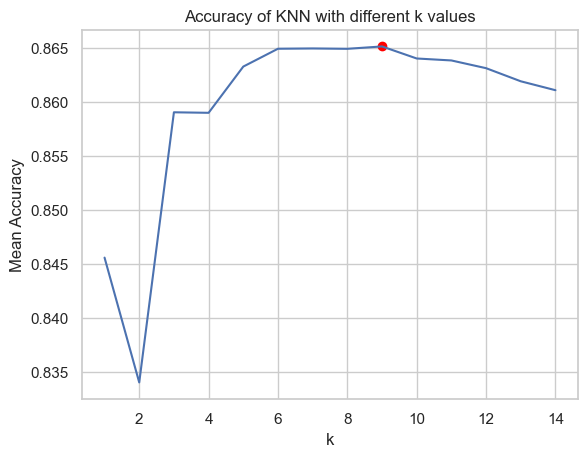

K with highest accuracy: 9. Accuracy: 0.8651042187760547


In [56]:
from joblib import Parallel, delayed
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
import numpy as np
import matplotlib.pyplot as plt

# define k values
k_values = range(1, 15)

# define random states
random_states = range(1, 2000)

# define function to compute accuracy for a given k value and random state
def compute_accuracy(k, random_state):
    # split the data into training and remainder set
    x_train, x_remainder, y_train, y_remainder = train_test_split(standard_scaled_data, y, test_size=test_size, random_state=random_state, stratify=y)

    # split the remainder data into validation and test set
    x_val, x_test, y_val, y_test = train_test_split(x_remainder, y_remainder, test_size=0.5, random_state=random_state, stratify=y_remainder)

    # define KNN classifier
    knn = KNeighborsClassifier(n_neighbors=k)

    # fit the model
    knn.fit(x_train, y_train)

    # predict the labels of the validation set
    y_pred = knn.predict(x_val)

    # compute the accuracy score
    return accuracy_score(y_val, y_pred)

# loop over k values in parallel
results = Parallel(n_jobs=-1)(delayed(compute_accuracy)(k=k, random_state=random_state) for k in k_values for random_state in random_states)

# compute the average accuracies for each k value
mean_accuracies = np.array(results).reshape(-1, len(random_states)).mean(axis=1)

# find the k value with the highest accuracy
best_k = k_values[np.argmax(mean_accuracies)]
best_accuracy = mean_accuracies.max()

# plot the mean accuracies and mark the maximum accuracy and k value
plt.plot(k_values, mean_accuracies)
plt.scatter(best_k, best_accuracy, color='red')
plt.xlabel("k")
plt.ylabel("Mean Accuracy")
plt.title("Accuracy of KNN with different k values")
plt.show()

# print the k value with the highest accuracy including the corresponding accuracy
best_index = np.argmax(mean_accuracies)
print("K with highest accuracy: {}. Accuracy: {}".format(best_k, best_accuracy))

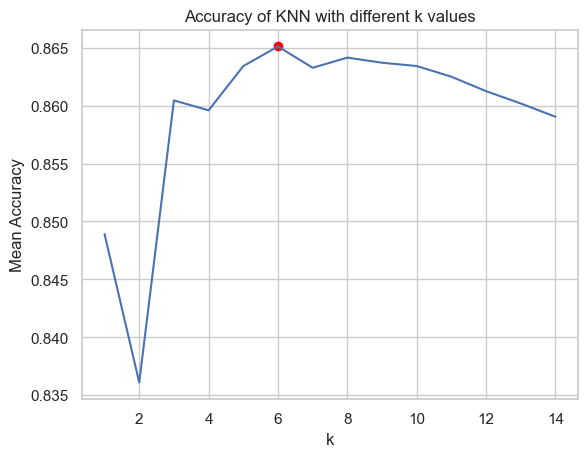

K with highest accuracy: 6. Accuracy: 0.865114223778556


In [57]:
from joblib import Parallel, delayed
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
import numpy as np
import matplotlib.pyplot as plt

# define k values
k_values = range(1, 15)

# define random states
random_states = range(1, 2000)

# define function to compute accuracy for a given k value and random state
def compute_accuracy(k, random_state):
    # split the data into training and remainder set
    x_train, x_remainder, y_train, y_remainder = train_test_split(minmax_scaled_data, y, test_size=test_size, random_state=random_state, stratify=y)

    # split the remainder data into validation and test set
    x_val, x_test, y_val, y_test = train_test_split(x_remainder, y_remainder, test_size=0.5, random_state=random_state, stratify=y_remainder)

    # define KNN classifier
    knn = KNeighborsClassifier(n_neighbors=k)

    # fit the model
    knn.fit(x_train, y_train)

    # predict the labels of the validation set
    y_pred = knn.predict(x_val)

    # compute the accuracy score
    return accuracy_score(y_val, y_pred)

# loop over k values in parallel
results = Parallel(n_jobs=-1)(delayed(compute_accuracy)(k=k, random_state=random_state) for k in k_values for random_state in random_states)

# compute the average accuracies for each k value
mean_accuracies = np.array(results).reshape(-1, len(random_states)).mean(axis=1)

# find the k value with the highest accuracy
best_k = k_values[np.argmax(mean_accuracies)]
best_accuracy = mean_accuracies.max()

# plot the mean accuracies and mark the maximum accuracy and k value
plt.plot(k_values, mean_accuracies)
plt.scatter(best_k, best_accuracy, color='red')
plt.xlabel("k")
plt.ylabel("Mean Accuracy")
plt.title("Accuracy of KNN with different k values")
plt.show()

# print the k value with the highest accuracy including the corresponding accuracy
best_index = np.argmax(mean_accuracies)
print("K with highest accuracy: {}. Accuracy: {}".format(best_k, best_accuracy))

In [58]:
# import classification report
from sklearn.metrics import classification_report

# compute the classification report
print(classification_report(y_val, y_pred))

              precision    recall  f1-score   support

         0.0       0.82      0.79      0.80        99
         1.0       0.83      0.82      0.83       101
         2.0       0.84      0.88      0.86       100

    accuracy                           0.83       300
   macro avg       0.83      0.83      0.83       300
weighted avg       0.83      0.83      0.83       300



In [32]:
# test the model on the test set with the minmax scaled data and the best k value found in the previous step
knn = KNeighborsClassifier(n_neighbors=6, metric="manhattan")
knn.fit(minmax_scaled_data, y)
y_pred = knn.predict(minmax_scaled_data)

# compute the accuracy score
accuracy_score(y, y_pred)

# print the accuracy score
print("Accuracy: {}".format(accuracy_score(y, y_pred)))

Accuracy: 0.907


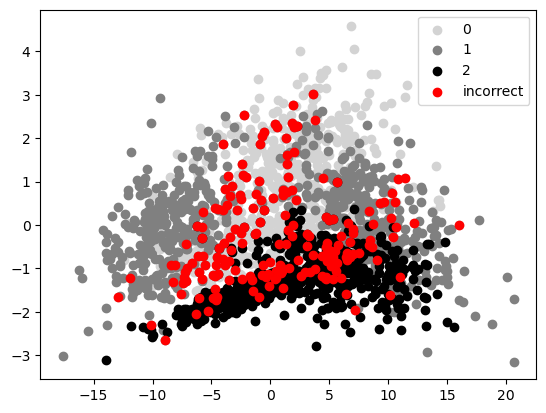

In [33]:
# plot the correct and incorrect predictions as scatter plots in different colors according to the true label
plt.scatter(x[y == 0, 0], x[y == 0, 1], color='lightgray', label='0')
plt.scatter(x[y == 1, 0], x[y == 1, 1], color='gray', label='1')
plt.scatter(x[y == 2, 0], x[y == 2, 1], color='black', label='2')
plt.scatter(x[y != y_pred, 0], x[y != y_pred, 1], color='red', label='incorrect')
plt.legend()
plt.show()

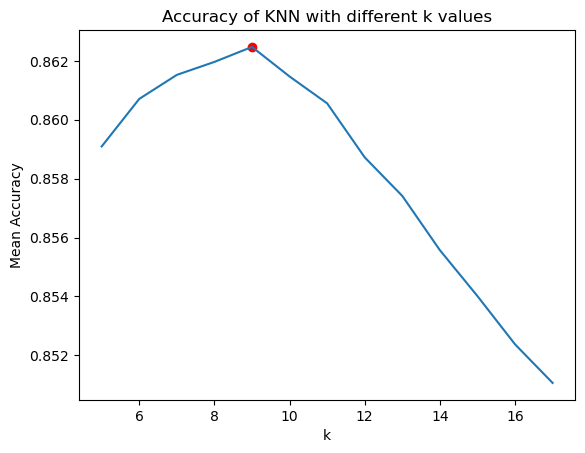

K with highest accuracy: 9. Accuracy: 0.8624729031182259


In [20]:
from joblib import Parallel, delayed
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
import numpy as np
import matplotlib.pyplot as plt

# define k values
k_values = range(5, 18)

# define random states
random_states = range(1, 2000)

# define function to compute accuracy for a given k value and random state
def compute_accuracy(k, random_state):
    # split the data into training and remainder set
    x_train, x_remainder, y_train, y_remainder = train_test_split(minmax_scaled_data, y, test_size=test_size, random_state=random_state, stratify=y)

    # split the remainder data into validation and test set
    x_val, x_test, y_val, y_test = train_test_split(x_remainder, y_remainder, test_size=0.5, random_state=random_state, stratify=y_remainder)

    # define KNN classifier
    knn = KNeighborsClassifier(n_neighbors=k, metric="chebyshev")

    # fit the model
    knn.fit(x_train, y_train)

    # predict the labels of the validation set
    y_pred = knn.predict(x_val)

    # compute the accuracy score
    return accuracy_score(y_val, y_pred)

# loop over k values in parallel
results = Parallel(n_jobs=-1)(delayed(compute_accuracy)(k=k, random_state=random_state) for k in k_values for random_state in random_states)

# compute the average accuracies for each k value
mean_accuracies = np.array(results).reshape(-1, len(random_states)).mean(axis=1)

# find the k value with the highest accuracy
best_k = k_values[np.argmax(mean_accuracies)]
best_accuracy = mean_accuracies.max()

# plot the mean accuracies and mark the maximum accuracy and k value
plt.plot(k_values, mean_accuracies)
plt.scatter(best_k, best_accuracy, color='red')
plt.xlabel("k")
plt.ylabel("Mean Accuracy")
plt.title("Accuracy of KNN with different k values")
plt.show()

# print the k value with the highest accuracy including the corresponding accuracy
best_index = np.argmax(mean_accuracies)
print("K with highest accuracy: {}. Accuracy: {}".format(best_k, best_accuracy))